In [28]:
import pandas as pd
from sklearn import tree
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection

# global size of label text for plots in the notebook
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
%matplotlib inline

In [7]:
df = pd.read_csv('./data/winequality-red.csv', sep=';')

In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [10]:
quality_mapping = {
    3: 0, 
    4: 1,
    5: 2, 
    6: 3, 
    7: 4,
    8: 5
}

In [11]:
df.loc[:, 'quality'] = df.quality.map(quality_mapping)

In [12]:
df.quality.unique()

array([2, 3, 4, 1, 5, 0])

In [13]:
df.shape

(1599, 12)

In [14]:
# shuffle dataframe and reset index after shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [15]:
# top 1000 rows for training
df_train = df.head(1000)

In [16]:
# last 599 rows for testing/validation
df_test = df.tail(599)

In [17]:
model = tree.DecisionTreeClassifier(max_depth=3)

In [18]:
features = df_train.drop('quality', axis=1)

In [19]:
target = df_train.quality

In [20]:
model.fit(features, target)

DecisionTreeClassifier(max_depth=3)

In [21]:
train_predictions = model.predict(features)
test_predictions = model.predict(df_test.drop('quality', axis=1))
train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)
test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)

In [22]:
print(f'Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')

Train accuracy: 0.572
Test accuracy: 0.5726210350584308


In [23]:
# depth = 7
model = tree.DecisionTreeClassifier(max_depth=7)

In [24]:
model.fit(features, target)
train_predictions = model.predict(features)
test_predictions = model.predict(df_test.drop('quality', axis=1))
train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)
test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)
print(f'Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')

Train accuracy: 0.759
Test accuracy: 0.5976627712854758


# Plotting models accuracy for different _depth_ values - Overfitting demo

In [25]:
train_accuracies = [0.5]
test_accuracies = [0.5]

In [26]:
for depth in range(1, 30): 
    model = tree.DecisionTreeClassifier(max_depth=depth)
    model.fit(features, target)
    train_predictions = model.predict(features)
    test_predictions = model.predict(df_test.drop('quality', axis=1))
    train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)
    test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    

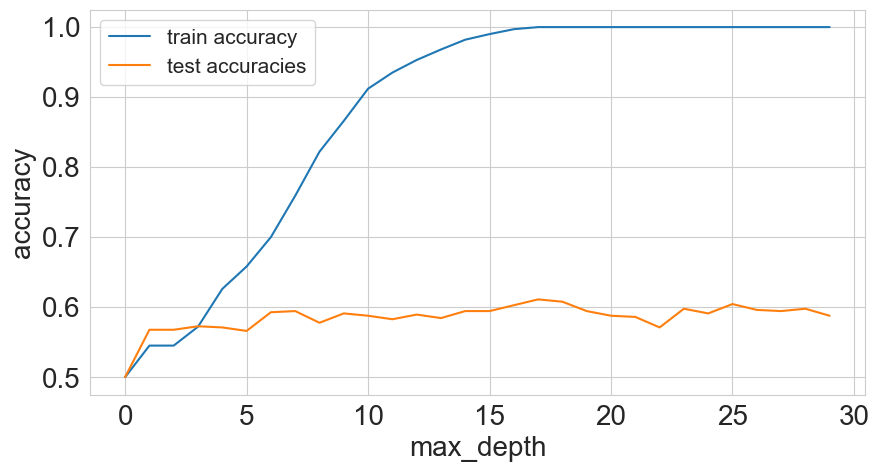

In [27]:
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracies')
plt.legend(loc='best', prop={'size':15})
plt.xticks(range(0, 31, 5))
plt.xlabel('max_depth', size=20)
plt.ylabel('accuracy', size=20)
plt.show()

# k-fold cross-validation

In [29]:
df['kfold'] = -1

In [30]:
df = df.sample(frac=1).reset_index(drop=True)

In [31]:
kf = model_selection.KFold(n_splits=5)

In [33]:
for fold, (trn_, val_) in enumerate(kf.split(X=df)): 
    df.loc[val_, 'kfold'] = fold

In [36]:
df.kfold.unique()

array([0, 1, 2, 3, 4])

# Stratified k-fold cross-validation

If you have a skewed dataset for binary classification with 90%  positive samples and only 10% negative samples, you don't want to use random k-fold cross-validation. Using simple k-fold cross-validation for a dataset like this can result in folds with all negative samples. In these cases, we prefer using stratified k-fold cross-validation. Stratified k-fold cross-validation keeps the ratio of labels in each fold constant.<br><br>
__NB:__ Cannot be used for regression problems in this setup. 

In [45]:
df = pd.read_csv('./data/winequality-red.csv', sep=';')

In [46]:
df.loc[:, 'quality'] = df.quality.map(quality_mapping)

In [47]:
df['kfold'] = -1

In [48]:
df = df.sample(frac=1).reset_index(drop=True)

In [49]:
y = df.quality.values

In [50]:
kf = model_selection.StratifiedKFold(n_splits=5)

In [51]:
for fold, (trn_, val_) in enumerate(kf.split(X=df, y=y)): 
    df.loc[val_, 'kfold'] = fold

In [52]:
df.kfold.unique()

array([0, 1, 2, 3, 4])

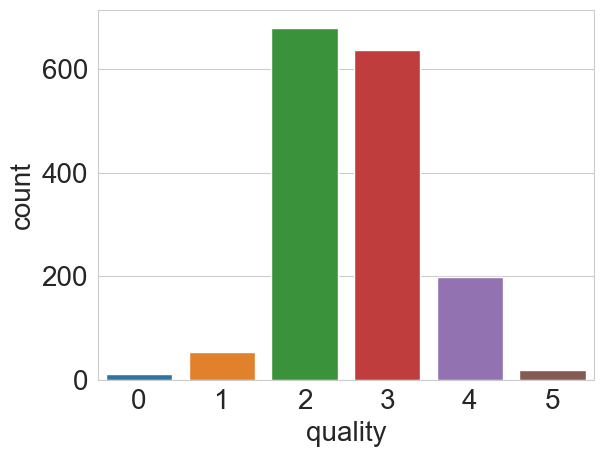

In [54]:
b = sns.countplot(x='quality', data=df)
b.set_xlabel('quality', fontsize=20)
b.set_ylabel('count', fontsize=20);

### Hold-out based validation

Suppose we have 1 million samples. A 5 fold cross-validation would mean training on 800k samples
and validating on 200k. Depending on which algorithm we choose, training and
even validation can be very expensive for a dataset which is of this size. In these
cases, we can opt for a __hold-out based validation__.  <br><br>
The process for creating the __hold-out__ remains the same as *__stratified k-fold__*. For a
dataset which has 1 million samples, we can create ten folds instead of 5 and keep
one of those folds as hold-out. This means we will have 100k samples in the hold-
out, and we will always calculate loss, accuracy and other metrics on this set and
train on 900k samples.

### Leave-one-out cross-validation

### Group k-fold cross-validation